## House Predict 
- https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/data

In [2]:
import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.model_selection import KFold, cross_validate, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# import scipy as sp
from scipy.stats import spearmanr

import os
from os.path import join

`sklearn.model_selection.StratifiedKFold`
- stratified k-fold cross-validation 
- 단순 k fold보다 이게 좋다
- scikit-learn에서는 cv 매개변수에 교차 검증 분할기cross-vailidation splitter를 전달함으로써 데이터를 분할할 때 더 세밀하게 제어할 수 있음
- 대부분의 경우 회귀에서는 k-겹 교차 검증, 분류에서는 계층별 k-겹 교차검증의 기본값이 잘 작동함  

`from sklearn.model_selection import  RepeatedStratifiedKFold`
- 얘는 stratifiedKFold 를 Repeat한거 
- 그런데 작은 dataset에서는 적합하나 딥러닝에서는 적합하지 않음. 계산할게 많아서
- 따라서 regression인 현 dataset에서는 진행하지 않음 

>> https://woolulu.tistory.com/70 

In [3]:
os.getcwd()

'/Users/js8456/google_drive/Colab_Notebook/aiffel_lms/E6_Kaggle'

In [4]:
root_path = '/Users/js8456/google_drive/Colab_Notebook/aiffel_lms/E6_Kaggle'
data_path = join(root_path, 'house_price_data')

train_path = join(data_path, 'train.csv')
test_path = join(data_path, 'test.csv')

In [5]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [6]:
print(train_df.shape, test_df.shape)
print(train_df.columns, test_df.columns) 

# Find out which column is difference between train & test
train_df_col = train_df.columns
test_df_col = test_df.columns
train_test_dif_col = train_df_col.difference(test_df_col)
train_test_dif_col 

# # As Function

# def com_dif_col_check(train, test):
#     train_test_common_col = []
#     train_test_dif_col = []

#     train_col = train.columns
#     test_col = test.columns
#     train_test_common_col.append(train_col.intersection(test_col))
#     train_test_dif_col.append(train_col.difference(test_col))

#     return common_col, train_only_col

# com_dif_col_check(train, test)

(15035, 21) (6468, 20)
Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object') Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


Index(['price'], dtype='object')

In [7]:
# change Exponential expression to regular format
pd.options.display.float_format = '{:.2f}'.format

In [8]:
train_df.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.00,3,1.00,1180,5650,1.00,0,0,...,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650
1,1,20150225T000000,180000.00,2,1.00,770,10000,1.00,0,0,...,6,770,0,1933,0,98028,47.74,-122.23,2720,8062
2,2,20150218T000000,510000.00,3,2.00,1680,8080,1.00,0,0,...,8,1680,0,1987,0,98074,47.62,-122.05,1800,7503
3,3,20140627T000000,257500.00,3,2.25,1715,6819,2.00,0,0,...,7,1715,0,1995,0,98003,47.31,-122.33,2238,6819
4,4,20150115T000000,291850.00,3,1.50,1060,9711,1.00,0,0,...,7,1060,0,1963,0,98198,47.41,-122.31,1650,9711


In [9]:
test_df.head(5)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.00,0,0,3,7,2170,400,1951,1991,98125,47.72,-122.32,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.00,0,0,5,7,1050,910,1965,0,98136,47.52,-122.39,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.00,0,0,3,11,3890,1530,2001,0,98053,47.66,-122.00,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.00,0,0,3,7,1050,730,1960,0,98146,47.51,-122.34,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.00,0,0,3,7,1890,0,2003,0,98038,47.37,-122.03,2390,7570


## Data Preprocessing 

1. DF
    - test와 train data 전처리 함께 진행하기 위해 concat 했다가 나중에 분리  
    - train에만 있는 Price column은 다른 곳에 저장해뒀다 추후 concat  
<br>

2. data modify
    - date 8자리 이후 삭제
    - yr_renovated 0 -> nan  
<br>

3. Outlier
    - 특이값 삭제   
<br>

4. Normalization 
    - 데이터 분포 확인 후 필요시 진행   

In [10]:
train_origin = train_df.copy()
train_price = train_df['price']
del train_df['price']

DF 정리  

    1. train_origin : origin data copy
    2. train_price : train 데이터의 price 값만 
    3. concat_df : train과 test 합친 data

In [11]:
train_len = len(train_df) # for spliting df later
concat_df = pd.concat((train_df, test_df), axis = 0)

In [12]:
# modifying date | split & Dtype change
concat_df['date'] = concat_df.date.str.split('T').str[0].astype(int)

# # different method 
# concat_df['date'] = concat_df['date'].apply(lambda x : x[:6]).astype(int)

In [13]:
# modifying yr_renovated == 0 to NaN
# nan 값 있으니까 model 돌릴 때 오류 occurred -> 우선 보류

# concat_df['yr_renovated'] = concat_df['yr_renovated'].apply(lambda x : np.nan if x == 0 else x)

In [14]:
concat_df.head(5)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013,3,1.00,1180,5650,1.00,0,0,3,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650
1,1,20150225,2,1.00,770,10000,1.00,0,0,3,6,770,0,1933,0,98028,47.74,-122.23,2720,8062
2,2,20150218,3,2.00,1680,8080,1.00,0,0,3,8,1680,0,1987,0,98074,47.62,-122.05,1800,7503
3,3,20140627,3,2.25,1715,6819,2.00,0,0,3,7,1715,0,1995,0,98003,47.31,-122.33,2238,6819
4,4,20150115,3,1.50,1060,9711,1.00,0,0,3,7,1060,0,1963,0,98198,47.41,-122.31,1650,9711


In [15]:
# null & Dtype check
# Normally Categorical Variables are object or string
# Numerical Variables int64 or float 64

concat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21503 entries, 0 to 6467
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21503 non-null  int64  
 1   date           21503 non-null  int64  
 2   bedrooms       21503 non-null  int64  
 3   bathrooms      21503 non-null  float64
 4   sqft_living    21503 non-null  int64  
 5   sqft_lot       21503 non-null  int64  
 6   floors         21503 non-null  float64
 7   waterfront     21503 non-null  int64  
 8   view           21503 non-null  int64  
 9   condition      21503 non-null  int64  
 10  grade          21503 non-null  int64  
 11  sqft_above     21503 non-null  int64  
 12  sqft_basement  21503 non-null  int64  
 13  yr_built       21503 non-null  int64  
 14  yr_renovated   21503 non-null  int64  
 15  zipcode        21503 non-null  int64  
 16  lat            21503 non-null  float64
 17  long           21503 non-null  float64
 18  sqft_li

In [16]:
# train price data check as df
train_price_df = pd.DataFrame(train_price, columns = ['price'])
train_price_df

,price
0,221900.00
1,180000.00
2,510000.00
3,257500.00
4,291850.00
...,...
15030,610685.00
15031,1007500.00
15032,360000.00
15033,400000.00


In [17]:
# train_df, test_df split
train_df = concat_df.iloc[:train_len, :]
test_df = concat_df.iloc[train_len:, :]

## Check most correlated variables with price
- continuous + sequential variables --> spearman

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<AxesSubplot:>

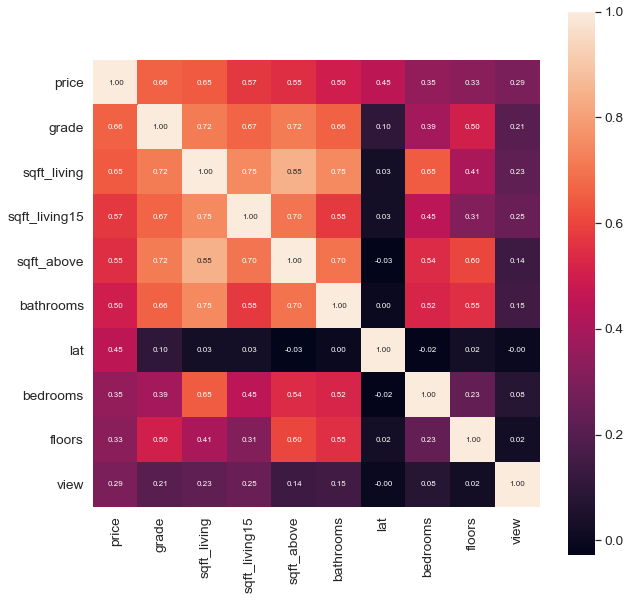

In [18]:
# 하나의 df로 corr 확인하기 위해서 train_df & train_price_df concat 진행 
# abs는 반비례관계도 고려하기 위함

train_total = pd.concat([train_df, train_price_df], axis = 1)
train_total

cor_abs = abs(train_total.corr(method = 'spearman'))
cor_abs_col = cor_abs.nlargest(n = 10, columns = 'price').index

# matrix
cor = np.array(spearmanr(train_total[cor_abs_col].values))[0]
print(cor_abs_col.values)

plt.figure(figsize = (10, 10))
sns.set(font_scale = 1.25)
sns.heatmap(cor, fmt = '.2f', annot = True, square = True, 
            annot_kws = {'size':8}, xticklabels = cor_abs_col.values, 
            yticklabels = cor_abs_col.values)



'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms' 'lat' 'bedrooms' 'floors' 'view' 의 순서대로 price에 영향력이 큰 변수임 

- 참고 : https://www.kaggle.com/junoindatascience/let-s-eda-it

* Rand Correlation 
    - -1: a perfect negative relationship between two variables
    - 0: no relationship between two variables
    - 1: a perfect positive relationship between two variables  

</br>

* p-value
    - p-value of the correlation is not less than 0.05, the correlation is not statistically significant.

## Important Variable | Outlier Check 
- outlier 삭제 기준 설정 
- train_total df를 이용해서 outlier 삭제한 후 다시 train_df와 train_price_df로 나누려고 함

In [19]:
cor_abs_col.values

array(['price', 'grade', 'sqft_living', 'sqft_living15', 'sqft_above',
       'bathrooms', 'lat', 'bedrooms', 'floors', 'view'], dtype=object)

#### 1. Grade & Price

In [20]:
# train_total['grade'].sort_values(ascending = False)
x = train_total.groupby('grade').count()
x

# grade 3, 13에 분포하는 data가 의미가 있을지 check 필요

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
grade,,,,,,,,,,,,,,,,,,,,
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
4,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23
5,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174
6,1406,1406,1406,1406,1406,1406,1406,1406,1406,1406,1406,1406,1406,1406,1406,1406,1406,1406,1406,1406
7,6228,6228,6228,6228,6228,6228,6228,6228,6228,6228,6228,6228,6228,6228,6228,6228,6228,6228,6228,6228
8,4207,4207,4207,4207,4207,4207,4207,4207,4207,4207,4207,4207,4207,4207,4207,4207,4207,4207,4207,4207
9,1855,1855,1855,1855,1855,1855,1855,1855,1855,1855,1855,1855,1855,1855,1855,1855,1855,1855,1855,1855
10,781,781,781,781,781,781,781,781,781,781,781,781,781,781,781,781,781,781,781,781


<AxesSubplot:xlabel='grade', ylabel='price'>

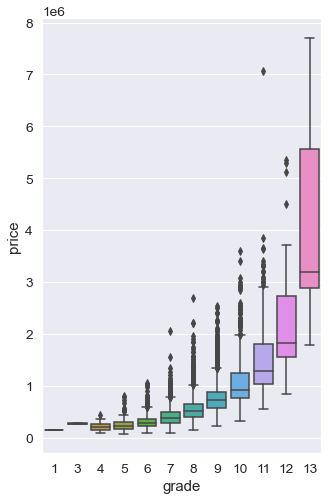

In [21]:
# grade variable & price outlier check 
fig, ax = plt.subplots(figsize = (5, 8))
sns.boxplot(x = 'grade', y = 'price', data = train_total)

# grade에 따라 price가 변한다는 것을 확인할 수 있음 
# outlier 꽤나 존재함 -> 7, 8, 9, 10, 11(high)
# grade 3는 4보다 grade가 낮으나 더 높은 price를 보유하고 있음 
# grade 13은 price의 차이가 매우 큼 

1. box plot을 기준으로 quantile 25-75 기준에서 outlier가 존재하는 것을 확인할 수 있는데, 여기의 outlier에서도 outlier로 취급되는 point들을 삭제
2. grade 3의 data 2개는 삭제해도 되는 것으로 고려됨

In [22]:
# remove high distance outlier 
a = train_total.loc[(train_total['grade'] == 7) & (train_total['price'] > 2000000)].index.values.tolist()
b = train_total.loc[(train_total['grade'] == 8) & (train_total['price'] > 2100000)].index.values.tolist()
c = train_total.loc[(train_total['grade'] == 11) & (train_total['price'] > 7000000)].index.values.tolist()
d = train_total.loc[(train_total['grade'] == 12) & (train_total['price'] > 4000000)].index.values.tolist()

opt = [*a, *b, *c, *d] 
opt

print(len(train_total))
train_total.drop(train_total.index[opt], axis = 0, inplace = True)
print(len(train_total)) # len으로 row 삭제 확인 

15035
15026


In [23]:
# remove grade 3 data
train_total = train_total[train_total['grade'] != 3]


#### 2. sqft_livings, qft_living15 & price

In [24]:
# sqft_living과 sqft_living의 차이가 무엇인지 확인해야 함 
# 우선 둘이 연관성이 있는지 확인 -> 0.75의 높은 연관성 보임 
sqft_living_df = pd.concat([train_total['sqft_living'], train_total['sqft_living15']], axis = 1)
sqft_living_corr = sqft_living_df.corr(method = 'spearman')
sqft_living_corr



,sqft_living,sqft_living15
sqft_living,1.00,0.75
sqft_living15,0.75,1.00


In [25]:
# train price range check 
train_total['price'].sort_values(ascending=False)

5108    7700000.00
6469    6885000.00
3134    5570000.00
1499    3850000.00
4957    3800000.00
           ...    
2674      84000.00
12841     83000.00
11293     81000.00
339       80000.00
10678     78000.00
Name: price, Length: 15024, dtype: float64

<AxesSubplot:xlabel='price', ylabel='sqft_living15'>

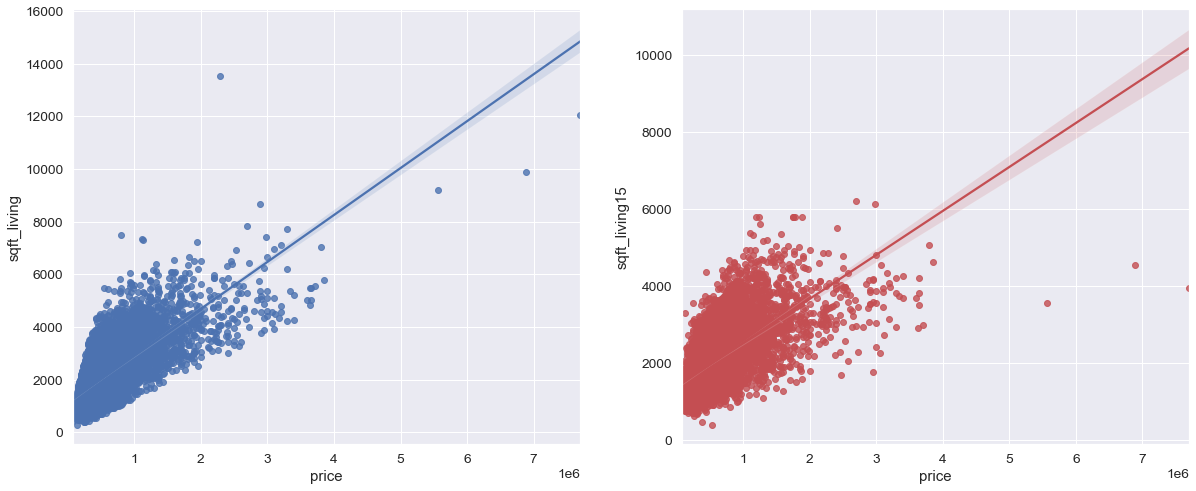

In [26]:
# fit_reg = True로 진행 

fig, axs = plt.subplots(ncols=2)
fig.set_size_inches(20, 8)
sns.regplot(x='price', y='sqft_living', data=train_total, ax=axs[0], fit_reg = True, color = 'b')
sns.regplot(x='price', y='sqft_living15', data=train_total, ax=axs[1], fit_reg = True, color = 'r')
# fit_reg 옵션은 회귀선 추가

- sqft_living15가 sqft_living보다 데이터의 분산이 넓기 때문에 price와의 상관관계가 더 두드러질 수 있는 sqft_living15를 사용하려 함
- 그런데 회귀선으로 보았을 때 outlier로 생각되는 point는 sqft_living에서 하나를 두드러지게 확인할 수 있어 : 해당 row 삭제하고자 함 

In [27]:
train_total[train_total['sqft_living']> 13000]
train_total = train_total.drop(index = 8912, axis = 0)

#### 3. sqft_above & price
- 지하실 제외 평방 피트 

<AxesSubplot:xlabel='price', ylabel='sqft_above'>

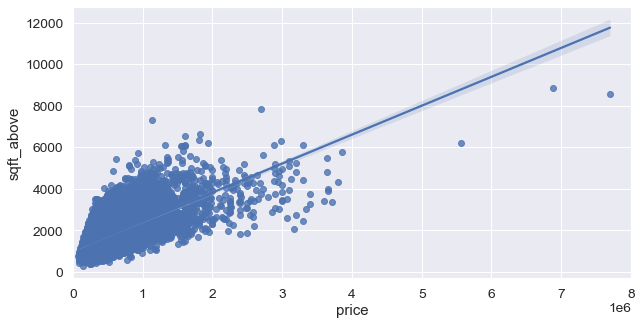

In [28]:
fig, ax = plt.subplots(ncols=1)
fig.set_size_inches(10, 5)
ax.set_xlim([0, 8000000])
sns.regplot(x='price', y='sqft_above', data=train_total, color = 'b')

# 이정도 outlier은 그냥 두고자 함 

'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms' 'lat' 'bedrooms' 'floors' 'view' 의 순서대로 price에 영향력이 큰 변수임 

#### 4. bathrooms

<AxesSubplot:xlabel='bathrooms', ylabel='price'>

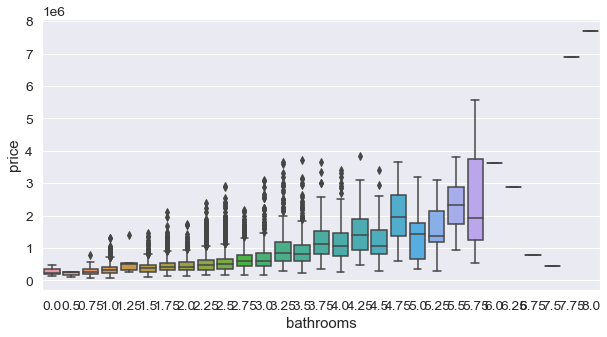

In [29]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.boxplot(x = 'bathrooms', y = 'price', data = train_total)

In [30]:
# bathrooms 6.25개부터는 price랑 전혀 상관없이 나옴 
a = train_total[train_total['bathrooms'] > 6.0].index.values.tolist()

train_total = train_total.drop(index = a)

#### lat

<AxesSubplot:xlabel='lat', ylabel='price'>

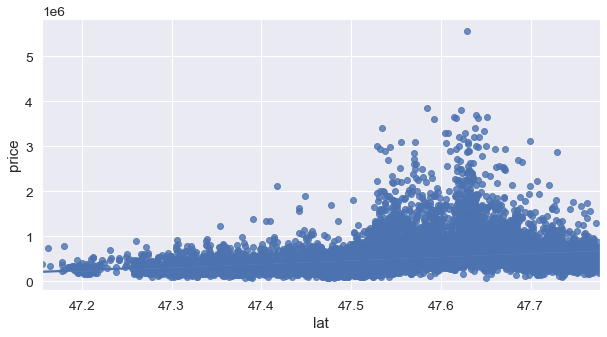

In [31]:
fig, ax = plt.subplots(ncols=1)
fig.set_size_inches(10, 5)
sns.regplot(x='lat', y='price', data=train_total, fit_reg = True, color = 'b')

# price 혼자 튀어나와있는 outlier만 삭제 

In [32]:
train_total[(train_total['price'] > 5000000) & (train_total['lat']> 47.6)]
train_total = train_total.drop(index = 3134)

train_total['price'].max()

3850000.0

- 그런데 이렇게 되면 `train_total['price'].max()` 로 확인할 수 있듯이 high price를 outlier로 거의 삭제를 한 것과 마찬가지임
- Proceed

In [33]:
# 기존 data price check
train_origin['price'].sort_values(ascending = False).head(20)

5108    7700000.00
2775    7062500.00
6469    6885000.00
3134    5570000.00
1045    5350000.00
947     5300000.00
842     5110800.00
1882    4500000.00
1499    3850000.00
4957    3800000.00
11364   3710000.00
4598    3650000.00
12848   3650000.00
10645   3640900.00
13311   3635000.00
2049    3600000.00
5621    3400000.00
7297    3400000.00
14231   3345000.00
12845   3300000.00
Name: price, dtype: float64

#### Normalization 

In [34]:
train_total['price'].describe()
# high std check -> left skewed shape

count     15017.00
mean     537096.32
std      347385.18
min       78000.00
25%      321500.00
50%      450000.00
75%      645000.00
max     3850000.00
Name: price, dtype: float64

In [35]:
print(train_total['price'].skew(), train_total['price'].kurt()) # graph wideness check 

# Normal distribution kurtosis 3
# Need Normalization

2.9907729010579875 14.72835908492317


<AxesSubplot:xlabel='price', ylabel='Density'>

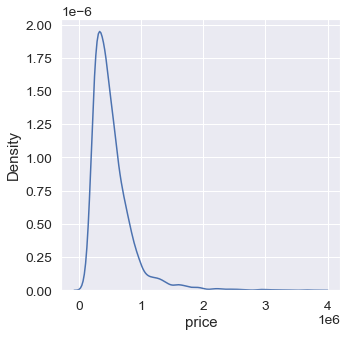

In [36]:
# price skew 부터 확인 
fig, ax = plt.subplots(figsize = (5,5))
sns.kdeplot(train_total['price'])


Normalized 필요한 다른 변수들 또한 확인 (train_total 기준)

In [37]:
train_total.columns
print(len(train_total.columns))
train_total.info()


21
<class 'pandas.core.frame.DataFrame'>
Int64Index: 15017 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15017 non-null  int64  
 1   date           15017 non-null  int64  
 2   bedrooms       15017 non-null  int64  
 3   bathrooms      15017 non-null  float64
 4   sqft_living    15017 non-null  int64  
 5   sqft_lot       15017 non-null  int64  
 6   floors         15017 non-null  float64
 7   waterfront     15017 non-null  int64  
 8   view           15017 non-null  int64  
 9   condition      15017 non-null  int64  
 10  grade          15017 non-null  int64  
 11  sqft_above     15017 non-null  int64  
 12  sqft_basement  15017 non-null  int64  
 13  yr_built       15017 non-null  int64  
 14  yr_renovated   15017 non-null  int64  
 15  zipcode        15017 non-null  int64  
 16  lat            15017 non-null  float64
 17  long           15017 non-null  float64
 18  sqf

In [38]:
len(train_total.columns)
# train_total.columns

21

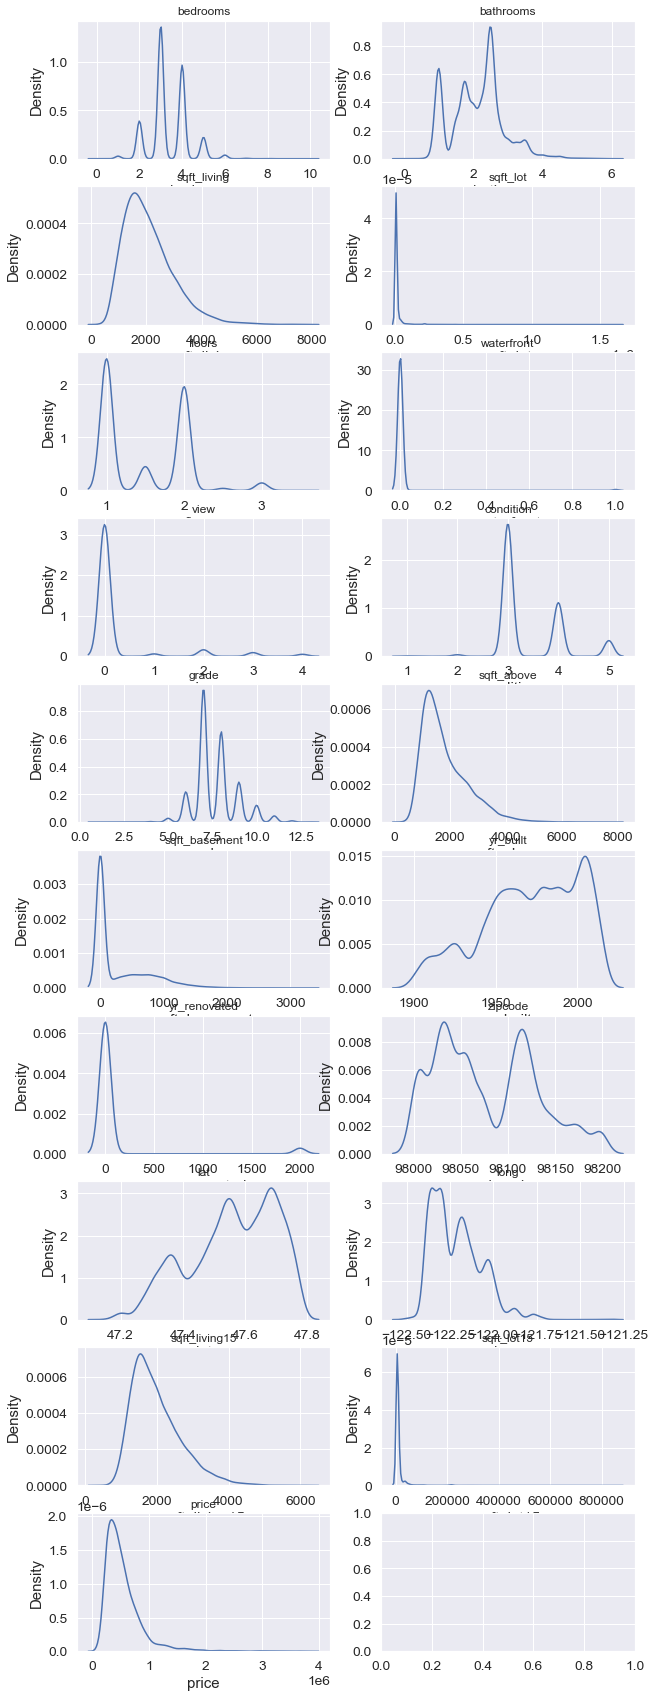

In [39]:
# check which variables need to be Normalized

fig, ax = plt.subplots(10, 2, figsize=(10, 30))   

count = 2 # id, date don't need to be checked
columns = train_total.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(train_total[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=12)
        # print(train_total[columns[count]])
        count += 1
        if count == 21 :
            break

In [40]:
skew_columns = ['sqft_living', 'sqft_lot', 'waterfront','view', 'sqft_above', 'sqft_basement', 'sqft_above', 'sqft_basement', 'yr_renovated', 'sqft_living15']

for c in skew_columns:
    train_total[c] = np.log1p(train_total[c].values)


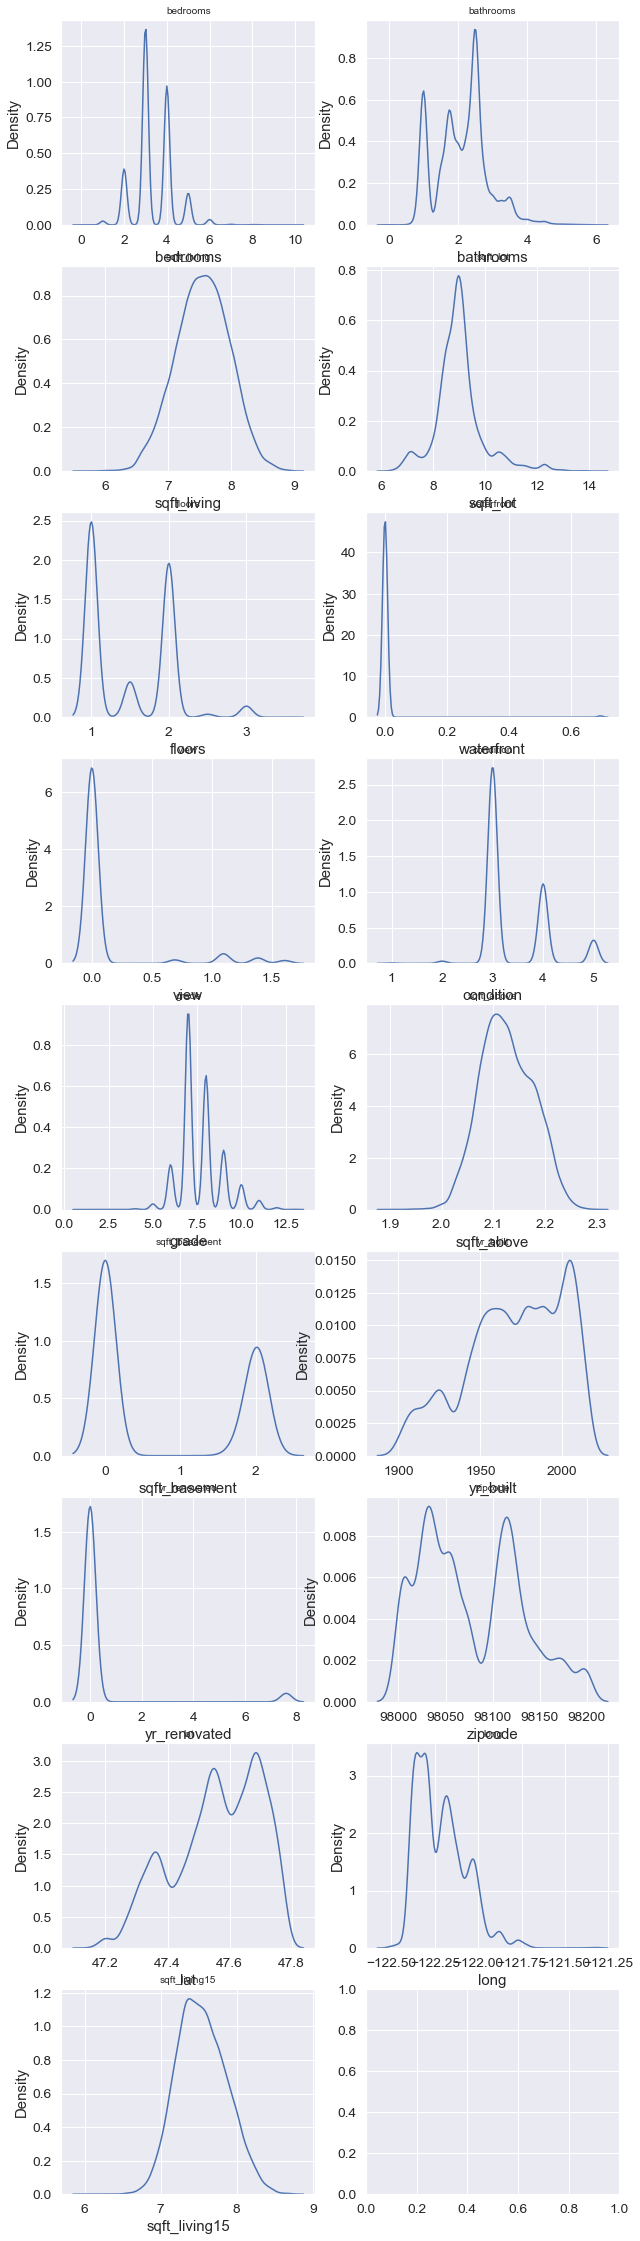

In [41]:
# check which variables need to be Normalized

fig, ax = plt.subplots(9, 2, figsize=(10, 40))

count = 2 # id, date don't need to be checked
columns = train_total.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(train_total[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=10)
        count += 1
        if count == 19 :
            break

#### Train x & y Split

In [42]:
train_df = train_total.iloc[:, :-1]
train_price = train_total.iloc[:, -1]

### Model Blending 

* Boosting
  - 여러개의 약한 learner을 순차적으로 학습-예측하여 잘못 예측한 데이터에 w를 수정해가면서 오류를 개선하는 학습 방식
  - 순차적 계산이기에 병렬연산 불가 
  - 종류
    - Adaboost : 잘못 분류한 데이터에 가중치를 부여, 다음 분류기가 더 좋게 만듦. outlier에 민감
    - Gradient Boost : w 업데이트를 gradient로 
    - XGBoost : 병렬 CPU 사용. overfitting 개선
    - LightGBM : 적은 용량을 사용하여 비슷한 예측값을 가질 수 있다는 장점이 있으나 data가 적을 경우 overfitting 가능. 보통 tree 기반 알고리즘은 트리 깊이는 줄이기 위해 균형트리분할 방식을 이용하지만 얘는 리프 중심 트리분할을 사용 즉, 비대칭이지만 낮은 loss 값을 가질 수 있는 것 

* Stacking 
  - ML 알고리즘으로 train dataset을 통해 새로운 dataset 만들고 다시 이걸 이용해서 ML algorithm 돌림
  - 보통 다른 타입의 모델을 사용함 
  - 성능이 비슷한 model들을 stacking하여 예측 데이터를 만든 다음 학습데이터로 사용할 최종 model을 이용함 
  - model -> dataset 생성 -> model 사용 하는 과정으로 인해 meta-model이라고도 함  

* Blending
  - stacking과 비슷
  - stacking은 cross-fold-validation을 사용하지만 blending은 holdout validation(train, validation, test dataset으로 나눠서 검증하는 형태)을 사용  


>> 참고페이지  
>> https://subinium.github.io/introduction-to-ensemble-1/#:~:text=%EC%95%99%EC%83%81%EB%B8%94(Ensemble)%20%ED%95%99%EC%8A%B5%EC%9D%80%20%EC%97%AC%EB%9F%AC,%EB%A5%BC%20%EA%B0%80%EC%A7%80%EA%B3%A0%20%EC%9D%B4%ED%95%B4%ED%95%98%EB%A9%B4%20%EC%A2%8B%EC%8A%B5%EB%8B%88%EB%8B%A  
>> https://gentlej90.tistory.com/73


In [43]:
train_df

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013,3,1.00,7.07,8.64,1.00,0.00,0.00,3,7,2.09,0.00,1955,0.00,98178,47.51,-122.26,7.20,5650
1,1,20150225,2,1.00,6.65,9.21,1.00,0.00,0.00,3,6,2.03,0.00,1933,0.00,98028,47.74,-122.23,7.91,8062
2,2,20150218,3,2.00,7.43,9.00,1.00,0.00,0.00,3,8,2.13,0.00,1987,0.00,98074,47.62,-122.05,7.50,7503
3,3,20140627,3,2.25,7.45,8.83,2.00,0.00,0.00,3,7,2.13,0.00,1995,0.00,98003,47.31,-122.33,7.71,6819
4,4,20150115,3,1.50,6.97,9.18,1.00,0.00,0.00,3,7,2.08,0.00,1963,0.00,98198,47.41,-122.31,7.41,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,20141014,4,2.50,7.83,8.70,2.00,0.00,0.00,3,9,2.18,0.00,2014,0.00,98056,47.51,-122.17,7.83,6023
15031,15031,20150326,4,3.50,8.16,8.88,2.00,0.00,0.00,3,9,2.18,2.06,2009,0.00,98136,47.55,-122.40,7.63,6200
15032,15032,20140521,3,2.50,7.33,7.03,3.00,0.00,0.00,3,8,2.12,0.00,2009,0.00,98103,47.70,-122.35,7.33,1509
15033,15033,20150223,4,2.50,7.75,8.67,2.00,0.00,0.00,3,8,2.17,0.00,2014,0.00,98146,47.51,-122.36,7.51,7200


### USE 
1. Linear Regression
2. Bagging
    - RandomForest Regression : Tree correlation 문제 있으니(tree들이 비슷하게 생성되는 것을 고려하지 못하는 점) 데이터 샘플링시에 일부 feature들만 일부 선택하여 다른 feature들로 학습하게 하는 방법을 사용 
2. Boosting : 이전 모델들의 error데이터 이용 가중치 부여 학습 
    - Gradientboost
    - Xgboost
    - Lightgbm

3. Blending

In [51]:
# random_state setting
random_state = 100

# Reverse log1p
def rmse(y_test, y_pred):
  return (np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred))))


#### Linear Regression

In [52]:
# train_columns = [c for c in train_df.columns if c not in ['id', 'data']]
linear_regression = LinearRegression()
result_linear_model = linear_regression.fit(train_df, train_price)

In [54]:
# Linear Regression Predict
result_linear = np.expm1(result_linear_model.predict(test_df))
result_linear


/Users/js8456/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in expm1
  


array([inf, inf, inf, ..., inf, inf, inf])

In [47]:
# # Train_linear regression score
result_linear.score(train_df, train_price)

0.6794655995462114

In [48]:
print(linear_regression.intercept_)
coeff_linear = pd.DataFrame(linear_regression.coef_, concat_df.columns, columns=['Coefficient'])
coeff_linear

-51853685.0241367


,Coefficient
id,2.05
date,2.97
bedrooms,-13538.66
bathrooms,68561.56
sqft_living,28712.98
sqft_lot,-5714.88
floors,5465.72
waterfront,766218.31
view,127982.92
condition,29625.20


* 해석  
Holding all other features fixed, a 1 unit increase in bathroom is associated with an increase of 68561.56.

#### Set Prediction document 
- sample_submission이 제출용 : id, price 컬럼 존재 

In [50]:
submission_path = join(root_path, 'house_price_data/sample_submission.csv')
submission = pd.read_csv(submission_path)
# submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [ ]:
submission['price'] = result_linear
submission.head()

In [56]:
submission_csv_path = '{}/submission_{}.csv'.format(root_path, 'linear')
submission.to_csv(submission_csv_path, index=False)


save_submission_linear(model, train, y, test, 'lgbm', rmsle='0.0168')

### Bagging | RandomForest Regression

In [70]:
# ramdomizedsearchcv 없이 일반적으로 진행했을 떄 
rf_org = RandomForestRegressor(random_state = random_state)
rf_org.fit(train_df, train_price)

result_rf = rf_org.predict(test_df)



In [71]:
# Usable options check 
print(rf_org.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 100, 'verbose': 0, 'warm_start': False}


RandomizedSearchCV는 뒤에서 Boosting과 함께 진행 

In [91]:
# Bagging_random_param_distributions

bagging_param_random = {'bootstrap': [True, False],
            'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
            'max_features': ['auto', 'sqrt'],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10],
            'n_estimators': [130, 180, 230]}

In [92]:
# RandomizedSearchCV
rf = RandomForestRegressor(random_state = random_state)

rf_random = RandomizedSearchCV(estimator = rf, 
                        param_distributions = bagging_param_random, 
                        scoring = 'neg_mean_squared_error',
                        n_iter = 100, cv = 3, verbose=2, 
                        random_state=random_state, n_jobs = -1)

# Fit the random search model
rf_random.fit(train_df, train_price)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 10.5min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [95]:
rf_random.best_params = rf_random.best_params_
rf_random.best_score = rf_random.best_score_
rf_random.best_estimator = rf_random.best_estimator_

In [98]:
print(rf_random.best_params_ , rf_random.best_score_)
# rf_random.best_estimator_

{'n_estimators': 230, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False} -16136793462.324806


In [101]:
rf_random = RandomForestRegressor(n_estimators = 230, min_samples_split= 2, 
                                min_samples_leaf = 1, max_features = 'sqrt', 
                                max_depth = 30, bootstrap = False, random_state = random_state)

rf_random.fit(train_df, train_price)
result_rf_random = np.expm1(rf_random.predict(test_df))
result_rf_random

/Users/js8456/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in expm1
  


array([inf, inf, inf, ..., inf, inf, inf])

In [102]:
result_rf_random

array([inf, inf, inf, ..., inf, inf, inf])

# Boosting 

In [73]:
gboost = GradientBoostingRegressor(random_state = random_state) #ensemble | boosting
xgboost = xgb.XGBRegressor(random_state = random_state)
lightgbm = lgb.LGBMRegressor(random_state = random_state)

# stack_models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
#         {'model':lightgbm, 'name':'LightGBM'}]

boosting_models = [gboost, xgboost, lightgbm]

#### Get Multiple Function's Score

In [112]:
# Boosting_random_param_distributions

boosting_param_random = {'max_depth': [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                        'n_estimators': [50, 100, 150, 200]}

In [113]:
# RandomizedSearchCV Function

def my_RandomSearch(model, train_df, price, boosting_param_random, verbose=2, n_jobs = 1):
    model = RandomizedSearchCV(model, param_distributions = boosting_param_random, 
                    scoring='neg_mean_squared_error', cv=3, verbose=verbose, n_jobs = n_jobs)
    
    model.fit(train_df, price)

    # 결과값 저장
    params = model.cv_results_['params']
    score = model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [114]:
# 최적의 조합 check 
gboost_random_model = my_RandomSearch(gboost, train_df, train_price, boosting_param_random)
xgboost_random_model = my_RandomSearch(xgboost, train_df, train_price, boosting_param_random)
lightgbm_random_model = my_RandomSearch(lightgbm, train_df, train_price, boosting_param_random)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=50, max_depth=60 ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... n_estimators=50, max_depth=60, total=   6.4s
[CV] n_estimators=50, max_depth=60 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s remaining:    0.0s


[CV] .................... n_estimators=50, max_depth=60, total=   6.5s
[CV] n_estimators=50, max_depth=60 ...................................
[CV] .................... n_estimators=50, max_depth=60, total=   6.4s
[CV] n_estimators=150, max_depth=30 ..................................
[CV] ................... n_estimators=150, max_depth=30, total=  19.7s
[CV] n_estimators=150, max_depth=30 ..................................
[CV] ................... n_estimators=150, max_depth=30, total=  19.6s
[CV] n_estimators=150, max_depth=30 ..................................
[CV] ................... n_estimators=150, max_depth=30, total=  20.7s
[CV] n_estimators=100, max_depth=60 ..................................
[CV] ................... n_estimators=100, max_depth=60, total=  13.9s
[CV] n_estimators=100, max_depth=60 ..................................
[CV] ................... n_estimators=100, max_depth=60, total=  13.6s
[CV] n_estimators=100, max_depth=60 ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  5.0min finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=150, max_depth=100 .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................. n_estimators=150, max_depth=100, total=  22.6s
[CV] n_estimators=150, max_depth=100 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.6s remaining:    0.0s


[CV] .................. n_estimators=150, max_depth=100, total=  20.9s
[CV] n_estimators=150, max_depth=100 .................................
[CV] .................. n_estimators=150, max_depth=100, total=  20.7s
[CV] n_estimators=100, max_depth=30 ..................................
[CV] ................... n_estimators=100, max_depth=30, total=  11.7s
[CV] n_estimators=100, max_depth=30 ..................................
[CV] ................... n_estimators=100, max_depth=30, total=  12.4s
[CV] n_estimators=100, max_depth=30 ..................................
[CV] ................... n_estimators=100, max_depth=30, total=  12.6s
[CV] n_estimators=200, max_depth=10 ..................................
[CV] ................... n_estimators=200, max_depth=10, total=   5.0s
[CV] n_estimators=200, max_depth=10 ..................................
[CV] ................... n_estimators=200, max_depth=10, total=   5.2s
[CV] n_estimators=200, max_depth=10 ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  8.2min finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=50, max_depth=60 ...................................
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... n_estimators=50, max_depth=60, total=   0.6s
[CV] n_estimators=50, max_depth=60 ...................................
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] .................... n_estimators=50, max_depth=60, total=   0.6s
[CV] n_estimators=50, max_depth=60 ...................................
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV] .................... n_estimators=50, max_depth=60, total=   0.7s
[CV] n_estimators=200, max_depth=90 ..................................
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV] ................... n_estimators=200, max_depth=90, total=   2.7s
[CV] n_estimators=200, max_depth=90 ..................................
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV] ................... n_estimators=200, max_depth=90, total=   3.2s
[CV] n_estimators=200, max_depth=90 ..................................
[LightGBM] [Warning] Accuracy may be bad s

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   46.0s finished


#### Warning 확인 
[Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).

- 위의 내용을 기반으로 새롭게 다시 생성 

In [ ]:
test_df.insert(-1, 'price')

### boosting_param_random 으로 생성한 Model의 hyperparameters

In [118]:
# gboost_random_model

,n_estimators,max_depth,score,RMSLE
3,200,5,-13358793504.65,115580.25
5,50,10,-17191466880.95,131116.23
4,200,1,-27331136481.90,165321.31
0,50,60,-36889785271.97,192067.14
6,50,100,-36889785271.97,192067.14
7,50,40,-36889785271.97,192067.14
2,100,60,-37113431865.48,192648.47
9,100,90,-37113431865.48,192648.47
8,150,90,-37114602377.55,192651.50
1,150,30,-37382390270.59,193345.26


In [ ]:
# Use Hyperparameter from RandomSearchCV
gboost_final_model = GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=random_state)
gboost_final_model.fit(train_total, train_price)
gboost_final_prediction = np.expm1(gboost_final_model.predict(test_df))
gboost_final_prediction

# rmsle가 작아야 오류가 적다는 것

In [119]:
xgboost_random_model

,n_estimators,max_depth,score,RMSLE
2,200,10,-16426334411.85,128165.26
1,100,30,-18178655778.50,134828.25
8,150,40,-18187872777.85,134862.42
6,100,40,-18187883925.40,134862.46
3,200,90,-18191936256.40,134877.49
9,200,70,-18191936256.40,134877.49
0,150,100,-18191954255.34,134877.55
4,100,60,-18191972803.08,134877.62
7,200,20,-18238827076.98,135051.20
5,150,1,-24743568252.01,157300.88


NameError: name 'test_df' is not defined

In [122]:
# Use Hyperparameter from RandomSearchCV
xgboost_final_model = xgb.XGBRegressor(max_depth=10, n_estimators=200, random_state=random_state)
xgboost_final_model.fit(train_total, train_price)
xgboost_final_prediction = np.expm1(xgboost_final_model.predict(test_df))
xgboost_final_prediction

ValueError: feature_names mismatch: ['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'price'] ['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
expected price in input data

In [121]:
# lightgbm_random_model

,n_estimators,max_depth,score,RMSLE
1,200,90.00,-12723081590.41,112796.64
3,200,50.00,-12723081590.41,112796.64
5,200,40.00,-12723081590.41,112796.64
6,150,40.00,-12786706994.93,113078.32
8,100,60.00,-12947045265.15,113785.08
0,50,60.00,-13948507437.26,118103.80
2,50,40.00,-13948507437.26,118103.80
4,50,nan,-13948507437.26,118103.80
7,50,70.00,-13948507437.26,118103.80
9,100,1.00,-31885616699.67,178565.44


In [ ]:
# Use Hyperparameter from RandomSearchCV
light_final_model = lgb.LGBMRegressor(max_depth=10, n_estimators=200, random_state=random_state)
light_final_model.fit(train_total, train_price)
light_final_prediction = np.expm1(light_final_model.predict(test_df))
light_final_prediction

#### Blending 

In [ ]:
# models_1 includes only Boosting Method
models_1 = [{'model': gboost, 'name': 'GradientBoosting'}, \
            {'model': xgboost, 'name': 'XGBoost'}, \
            {'model': lightgbm, 'name': 'LightGBM'}]

# models_2 includes Boosting & Bagging Method 
models_2 = [{'model': gboost, 'name': 'GradientBoosting'}, \
            {'model': xgboost, 'name': 'XGBoost'}, \
            {'model': lightgbm, 'name': 'LightGBM'},\
            {'model': rf, 'name':'RandomForest'}]


In [ ]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

In [ ]:
submission['price'] = prediction
submission.head()

In [ ]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

In [ ]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

In [ ]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')